In [1]:
import os
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torchsummary import summary
import gc

In [2]:
dir_defects_path = "data/dataset/defects"
dir_non_defects_path = "data/dataset/nondefects"

In [3]:
## To clear graph memory
def flush():
  gc.collect()
  torch.cuda.empty_cache()

In [151]:
flush()

### Parameters

In [4]:
lr = 0.001
batch_size = 4
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
defect_list = glob.glob(os.path.join(dir_defects_path, '*.jpg'))
nondefect_list = glob.glob(os.path.join(dir_non_defects_path, '*.jpg'))

In [6]:
print(len(defect_list))
print(len(nondefect_list))

208
205


## Transform / Augment the defected images to increase the dataset

In [120]:
# augmented_defects_path = "data/dataset/defects_transform"

# if not os.path.exists(augmented_defects_path):
#     os.makedirs(augmented_defects_path)
    
# transform_image1 = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
# ])

# transform_image2 = transforms.Compose([
#     transforms.RandomRotation(degrees=45),
# ])

# transform_image3 = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=35), 
# ])


# for img_path in defect_list:
#     img = Image.open(img_path)
#     transformed1 = transform_image1(img)
#     transformed2 = transform_image2(img)
#     transformed3 = transform_image3(img)
    
#     base_name = os.path.basename(img_path)
#     save_path1 = os.path.join(augmented_defects_path, f"augmented1_{base_name}")
#     save_path2 = os.path.join(augmented_defects_path, f"augmented2_{base_name}")
#     save_path3 = os.path.join(augmented_defects_path, f"augmented3_{base_name}")
    
#     transformed1.save(save_path1)
#     transformed2.save(save_path2)
#     transformed3.save(save_path3)
    

In [7]:
defect_list[:6]

['data/dataset/defects/augmented3_d3.jpg',
 'data/dataset/defects/d7.jpg',
 'data/dataset/defects/augmented3_d29.jpg',
 'data/dataset/defects/augmented1_d23.jpg',
 'data/dataset/defects/d20.jpg',
 'data/dataset/defects/d23.jpg']

## Show some defect  images

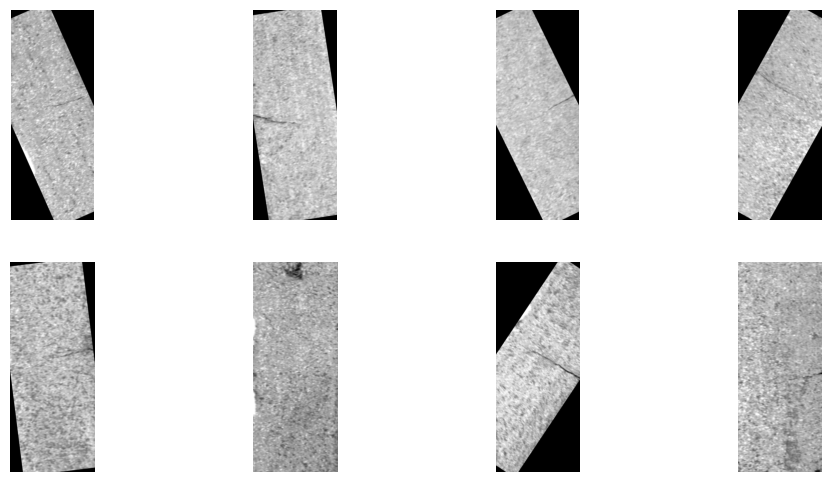

In [8]:
rand_ids = np.random.randint(1,len(defect_list),8)
figure = plt.figure(figsize=(12,6), dpi=100)
i = 1
for id in rand_ids:
    img = Image.open(defect_list[id])
    figure.add_subplot(2, 4, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    i+=1
plt.show()

## display few non-defect images

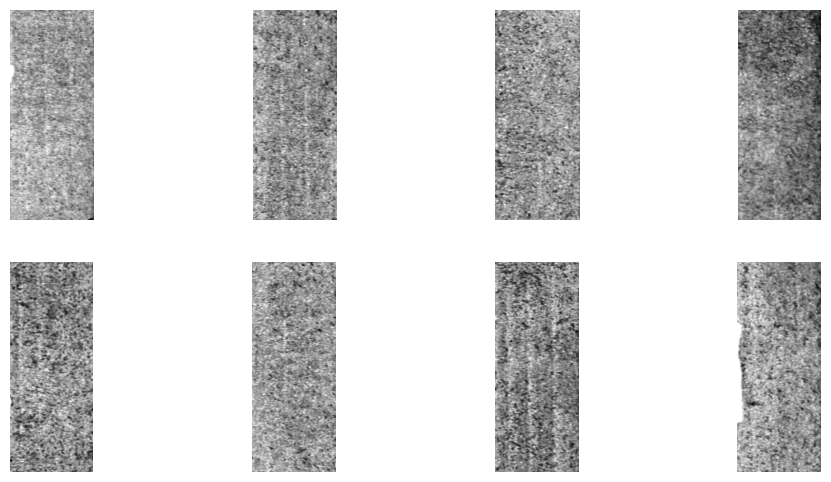

In [9]:
rand_ids = np.random.randint(1,len(nondefect_list),8)
figure = plt.figure(figsize=(12,6), dpi=100)
i = 1
for id in rand_ids:
    img = Image.open(nondefect_list[id])
    figure.add_subplot(2, 4, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    i+=1
plt.show()

In [10]:
transform_image = transforms.Compose([
    transforms.Resize((1250,500)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [11]:
class dataset(Dataset):
    def __init__(self, nondefected_list, defected_list, transform = None):
        self.images = nondefect_list + defect_list
        self.labels = [0] * len(nondefect_list) + [1] * len(defect_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
#         print(img.size)
        img_transform = self.transform(img)
#         print(img_transform.shape)
        return img_transform, label
        

In [13]:
imgs_dataset = dataset(nondefect_list, defect_list, transform_image)

# stratify ensures that both your training and validation sets have the same proportion 
# of defective and non-defective images as the original dataset.
train_idx, val_idx = train_test_split(list(range(len(imgs_dataset))), test_size=0.2, stratify=imgs_dataset.labels, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

In [14]:
len(imgs_dataset.labels)

413

In [15]:
imgs_dataset[0]

(tensor([[[0.7647, 0.7725, 0.7804,  ..., 0.7569, 0.7608, 0.7843],
          [0.7804, 0.7882, 0.7961,  ..., 0.7490, 0.7569, 0.7647],
          [0.7843, 0.7922, 0.8000,  ..., 0.7373, 0.7412, 0.7490],
          ...,
          [0.5765, 0.5686, 0.5608,  ..., 0.8157, 0.8157, 0.8078],
          [0.5843, 0.5843, 0.5804,  ..., 0.8078, 0.8118, 0.8000],
          [0.5922, 0.5882, 0.5843,  ..., 0.7922, 0.7922, 0.7882]]]),
 0)

In [16]:
train_loader = DataLoader(imgs_dataset, batch_size=4, sampler=train_sampler)
val_loader = DataLoader(imgs_dataset, batch_size=4, sampler=val_sampler)

In [17]:
for batch in train_loader:
    print(batch[1]) # just print the labels to see
    print(batch[0][0].shape)
    break

tensor([0, 1, 0, 1])
torch.Size([1, 1250, 500])


In [25]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
# as alexnet model recives 3 chanels in the firs layer and we have grayscale images we replace it
# model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
summary(model=model, input_size=(1, 1250, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 625, 250]           3,136
       BatchNorm2d-2         [-1, 64, 625, 250]             128
              ReLU-3         [-1, 64, 625, 250]               0
         MaxPool2d-4         [-1, 64, 313, 125]               0
            Conv2d-5         [-1, 64, 313, 125]          36,864
       BatchNorm2d-6         [-1, 64, 313, 125]             128
              ReLU-7         [-1, 64, 313, 125]               0
            Conv2d-8         [-1, 64, 313, 125]          36,864
       BatchNorm2d-9         [-1, 64, 313, 125]             128
             ReLU-10         [-1, 64, 313, 125]               0
       BasicBlock-11         [-1, 64, 313, 125]               0
           Conv2d-12         [-1, 64, 313, 125]          36,864
      BatchNorm2d-13         [-1, 64, 313, 125]             128
             ReLU-14         [-1, 64, 3

## Create Train and Test Loops

In [27]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    train_acc, train_loss = 0, 0 # train accuracy after one epoch
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        acc = ((output.argmax(dim=1) == label).float().mean())
        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # output lables of 100 images and compare witht the original labels get mean which is accuracy
        #print(output)

        train_acc += acc
        train_loss += loss
    train_acc = train_acc / len(train_loader)
    train_loss = train_loss / len(train_loader)
    print(f'Train Accuracy :{train_acc:.2f}%, train_loss: {train_loss:.2f}')

In [28]:
def test(test_loader, model, loss_fn):
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.no_grad():
        for data, label in test_loader:
            data , label = data.to(device), label.to(device)
            output = model(data)
            acc = ((output.argmax(dim=1) == label).float().mean())
            loss = loss_fn(output, label)
            # sum up the accuracy
            test_acc += acc
            test_loss += loss
    test_acc = test_acc/len(test_loader)
    test_loss = test_loss/ len(test_loader)
    print(f'Test Accuracy :{test_acc:.2f}%, Test_loss: {test_loss:.2f} \n')
        

In [33]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
print("Done!")

Epoch 1-------------------------------
Train Accuracy :0.99%, train_loss: 0.06
Test Accuracy :1.00%, Test_loss: 0.05 

Epoch 2-------------------------------
Train Accuracy :0.97%, train_loss: 0.11
Test Accuracy :0.89%, Test_loss: 0.30 

Epoch 3-------------------------------
Train Accuracy :0.92%, train_loss: 0.22
Test Accuracy :0.95%, Test_loss: 0.09 

Epoch 4-------------------------------
Train Accuracy :0.97%, train_loss: 0.11
Test Accuracy :1.00%, Test_loss: 0.03 

Epoch 5-------------------------------
Train Accuracy :0.98%, train_loss: 0.08
Test Accuracy :0.82%, Test_loss: 0.31 

Done!


## Test and Show some images

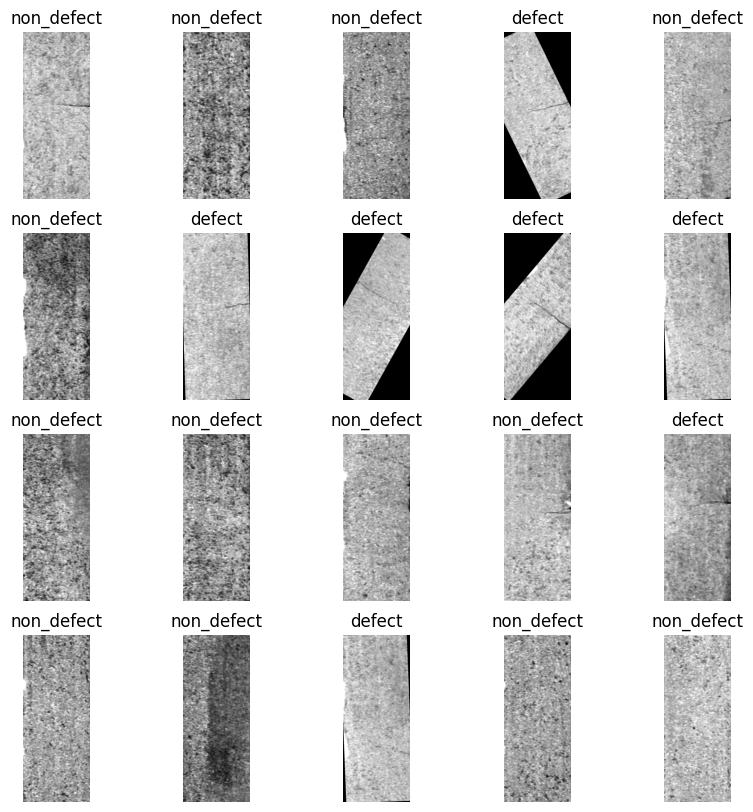

In [37]:
total_images = nondefect_list + defect_list

rand_ids = np.random.randint(1,len(total_images),20)
figure = plt.figure(figsize=(10,10))
i = 1
label = ''
model.eval()
with torch.no_grad():
    for id in rand_ids:
        img = Image.open(total_images[id])
        transformed = transform_image(img)
        transformed = transformed.unsqueeze(0)
        transformed = transformed.to(device)
        predict = model(transformed)
        predict_class = torch.argmax(predict)
        if predict_class == 0:
            label = 'non_defect'
        elif predict_class ==1:
            label = 'defect'
        figure.add_subplot(4, 5, i)
        plt.title(label)
        plt.axis('off')
        img = img.resize((500,1250), Image.Resampling.LANCZOS)
        plt.imshow(img, cmap='gray')
        i+=1
plt.show()